In [390]:
import pandas as pd
import matplotlib.pyplot as plt
from tdmsdata import TdmsData
import numpy as np
from scipy.optimize import curve_fit
from scipy.stats import gaussian_kde
import doppler_shift
import importlib


In [391]:
# inputs
file = '20231124_0955_Sn_118_res_scan.tdms'
channel = 1
isotope = 118

In [392]:
# Function to read TDMS file and extract raw data
def read_tdms(file, channel):
    TDMS = TdmsData(''.join(['/Users/xnimir/Desktop/Sn exp/Week47_17-11-2023/Isotope shift/{}'.format(file)]))
    raw_data = TDMS.get_raw_data(''.join(['Channel ', str(channel)]))  # 2D np array
    return raw_data

In [393]:
# Function to create a dataset from raw data
def create_df(raw_data):
    return pd.DataFrame({'Cycle': raw_data[:, 0], 'Time(sec)': raw_data[:, 1], 'Wavelength (nm)': raw_data[:, 2]})

In [394]:
def doppler_shift_calc(dataset):
    importlib.reload(doppler_shift)

    # Copying the original dataframe to avoid modifying it directly
    doppler_df = dataset.copy()

    # Get the original wavelengths from the dataframe 
    wavelengths = doppler_df['Wavelength (nm)']

    # Apply the Doppler shift to the wavelengths
    shifted_wls = doppler_shift.getshift(wavelengths, isotope)

    # Add the shifted wavelengths as a new column to the copied dataframe
    doppler_df['Wavelength (nm)'] = shifted_wls

    return doppler_df

In [395]:
def process_tdms(raw_df, bins):
    # Extract wavelengths and compute counts
    wavelengths_raw = raw_df['Wavelength (nm)']
    counts_df = wavelengths_raw.value_counts().reset_index()
    counts_df.columns = ['Wavelength', 'Count']

    # Skip the first row if needed
    counts_df = counts_df.iloc[1:].reset_index(drop=True)

    # Create bins and compute binned counts
    counts_df['Wavelength bin'] = pd.cut(counts_df['Wavelength'], bins)
    binned_counts_df = counts_df.groupby('Wavelength bin', observed=False)['Count'].sum().reset_index()

    # Compute bin midpoints
    binned_counts_df['Bin center'] = binned_counts_df['Wavelength bin'].apply(lambda x: x.mid)

    return counts_df, binned_counts_df 

In [396]:
def get_scatter_plot(wavelengths, counts):
    plt.scatter(wavelengths, counts)
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Count')
    plt.title('Wavelength Counts')
    plt.show()

    # Find the wavelength with the maximum count in raw data
    max_count_index = counts.idxmax()
    max_wavelength = wavelengths.loc[max_count_index]
    max_count = counts.loc[max_count_index]

    print(f'Peak WL: {max_wavelength} nm')


In [397]:
def gaussian(x, amplitude, mean, stddev):
    return amplitude * np.exp(-((x - mean) ** 2) / (2 * stddev ** 2))

In [398]:
def gaussian_fit(x_data, y_data, bins, file):
    # Initial guess for Gaussian parameters: amplitude, mean, stddev
    initial_guess = [max(y_data), np.mean(x_data), np.std(x_data)]

    # Perform Gaussian fit
    params, _ = curve_fit(gaussian, x_data, y_data, p0=initial_guess)

    # Generate points for plotting
    x_fit = np.linspace(min(x_data), max(x_data), 1000)
    y_fit = gaussian(x_fit, *params)

    y_errors = np.sqrt(y_data)

    # Plot binned counts with Gaussian fit
    plt.errorbar(x_data, y_data, yerr=y_errors, fmt='o',capsize=5, elinewidth=2, markersize=5)
    plt.plot(x_fit, y_fit, color='red')
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Count')
    plt.title(f'{file[14:20]} Gaussian fit, bins={bins}')
    plt.show()

    print(f'Peak: {params[1]}, FWHM: {2 * np.sqrt(2 * np.log(2)) * params[2]}')

In [399]:
# raw_data = read_tdms(file, channel)
# raw_df = create_df(raw_data)

# bins = 50
# counts_df, binned_counts_df = process_tdms(raw_df, bins)

# wavelengths = counts_df['Wavelength']
# counts = counts_df['Count']
# bin_center = binned_counts_df['Bin center'].cat.categories.astype(float)
# binned_counts = binned_counts_df['Count']
# # get_scatter_plot(wavelengths, counts)
# # get_scatter_plot(bin_center, binned_counts)
# gaussian_fit(bin_center, binned_counts, bins, file)


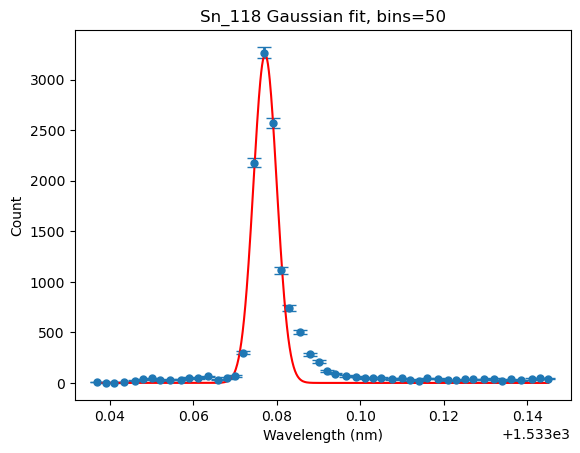

Peak: 1533.0771844415256, FWHM: 0.006561174448298584


In [400]:
# Doppler correction 
raw_data = read_tdms(file, channel)
raw_df = create_df(raw_data)
doppler_df = doppler_shift_calc(raw_df)

bins = 50
counts_df, binned_counts_df = process_tdms(doppler_df, bins)

wavelengths = counts_df['Wavelength']
counts = counts_df['Count']
bin_center = binned_counts_df['Bin center'].cat.categories.astype(float)
binned_counts = binned_counts_df['Count']
# get_scatter_plot(wavelengths, counts)
# get_scatter_plot(bin_center, binned_counts)
gaussian_fit(bin_center, binned_counts, bins, file)